In [ ]:
#|default_exp vision.learner

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *
from fastgs.vision.core import *

# Multi-spectral Vision Learner

> Learner support functions for working with `TensorImageMS`


## Show functions -

In [ ]:
#| export
def _get_sample_ctxs(nimgs: int, nsamples: int, mskovl: bool, figsize=None):
    nrows = 2 * nsamples if mskovl else nsamples
    ncols = nimgs if mskovl else nimgs + 2

    ctxs = get_grid(nrows * ncols, nrows, ncols, figsize=figsize, title='Ground Truth/Prediction')
    chksize = 2 * nimgs if mskovl else nimgs + 2
    return [ctxs[pos : pos + chksize] for pos in range(0, len(ctxs), chksize)]

In [ ]:
#| export
def _show_one_result(img: TensorImageMS, msk: TensorMask, out: TensorMask, row, mskovl: bool, **kwargs):
    if mskovl:
        rowl: int = len(row) // 2
        return [msk.show(ctx=c, **kwargs) for c in img.show(ctxs=row[:rowl],**kwargs)] + [out.show(ctx=c,**kwargs) for c in img.show(ctxs=row[rowl:],**kwargs)]
    else:
        nimgs: int = img.num_images()
        return img.show(ctxs=row[:nimgs],**kwargs) + [msk.show(ctx=row[nimgs],**kwargs)] + [out.show(ctx=row[nimgs+1],**kwargs)]

In [ ]:
from fastgs.geospatial.sentinel import *
from fastgs.vision.testio import *

In [ ]:
elvn_bands = Sentinel2(
    ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","AOT"],
    [Sentinel2.natural_color, ["B07","B06","B05"],["B12","B11","B8A"],["B08"]],
    get_channel_filenames,
    read_multichan_files,
    read_mask_file
)

elvn_imgs = elvn_bands.load_tensor(66)
elvn_mask = elvn_bands.load_mask(66)

def _show_one(mskovl):
    rowcx = _get_sample_ctxs(elvn_imgs.num_images(), 1, mskovl)
    _show_one_result(elvn_imgs, elvn_mask, elvn_mask, rowcx[0], mskovl)

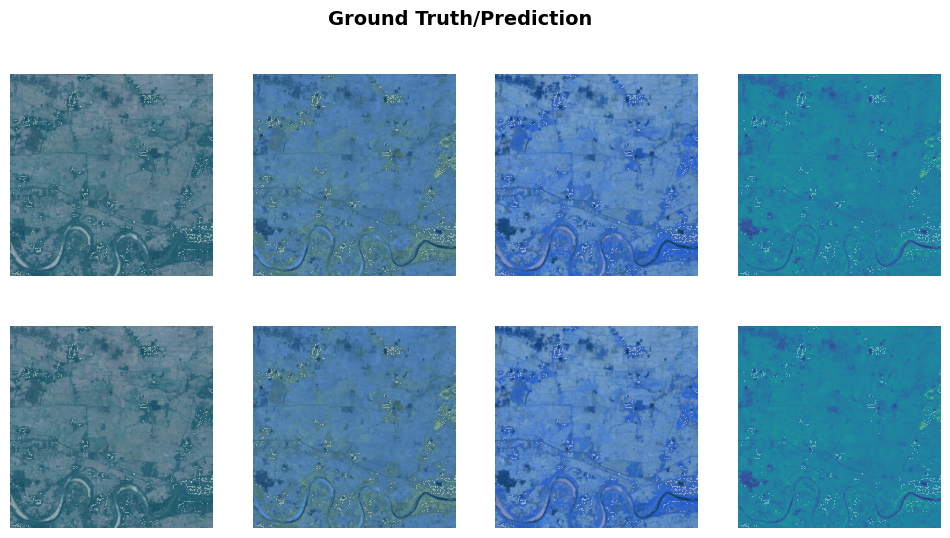

In [ ]:
_show_one(True)

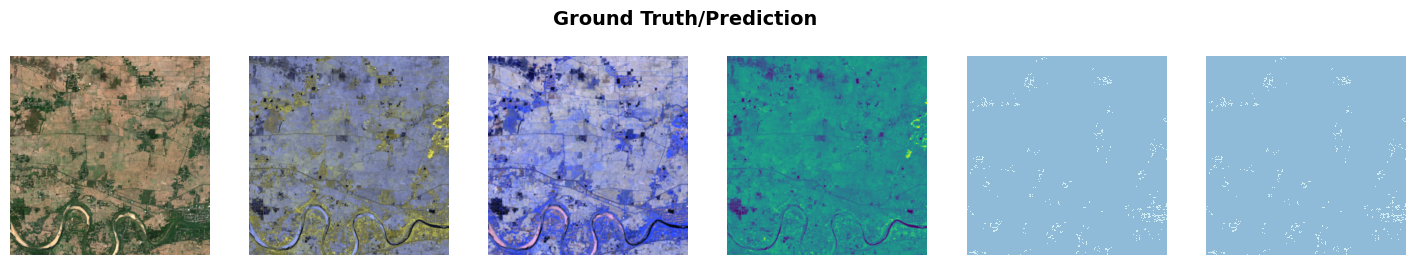

In [ ]:
_show_one(False)

In [ ]:
#|export
@typedispatch
def show_results(x:TensorImageMS, y:TensorMask, samples, outs, ctxs=None, max_n=6,
                 nrows:int=None, ncols:int=None, figsize=None, mskovl:bool=True, **kwargs):
    assert nrows is None and ncols is None and ctxs is None

    rwcx = _get_sample_ctxs(x.num_images(), min(len(samples),max_n), mskovl, figsize)
    imgs,msks,otps = samples.itemgot(0),samples.itemgot(1),outs.itemgot(0)
    return [_show_one_result(img, msk, otp[0], row, mskovl, **kwargs) for img,msk,otp,row in zip(imgs, msks, outs, rwcx)]

In [ ]:
#|export
@typedispatch
def plot_top_losses(x:TensorImageMS, y:TensorMask, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axes = get_grid(len(samples)*3, nrows=len(samples), ncols=3, figsize=figsize, flatten=False, title="Input | Target | Prediction")
    if axes.ndim == 1: axes = (axes,)
    titles = ["input", "target", "pred"]
    for axs,s,o,l in zip(axes, samples, outs, losses):
        imgs = (s[0], s[1], o[0])
        for ax,im,title in zip(axs, imgs, titles):
            if title=="pred": title += f"; loss = {l:.4f}"
            im.show(ctx=ax, **kwargs)
            ax.set_title(title)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()